In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

model_name = 'gpt2-medium'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [2]:
import pandas as pd

time_steps = 8
choices_per_step = 5

def get_next_token_greedy_search(input_txt, input_ids):
    """
    Performs greedy search for the next tokens in a text sequence using a trained model.

    Args:
        input_txt (str): The input text sequence.
        input_ids (torch.Tensor): The input tensor containing tokenized text sequence.

    Returns:
        pd.DataFrame: DataFrame containing the decoding iterations and predicted token choices.

    """
    iterations = []
    # We run the decoding for eight timesteps.
    with torch.no_grad():
        for _ in range(time_steps):
            iteration = dict()
            iteration["Input"] = tokenizer.decode(input_ids[0])
            output = model(input_ids=input_ids)
            # print('output.logits ', output.logits)
            # output.logits is 3-D Tensor
            # Select logits of the first batch and the last token
            next_token_logits = output.logits[0, -1, :]
            # next_token_logits is a 1-D Tensor
            # print(next_token_logits)
            # tensor([-100.3290,  -99.9514, -105.3466,  ..., -108.7789, -104.5404,-100.8237])

            # Now apply softmax
            next_token_probabilities = torch.softmax(next_token_logits, dim=-1)

            # torch.argsort => Returns the indices that sort a tensor along a given dimension
            sorted_indices_of_next_token_proba = torch.argsort(next_token_probabilities, dim=-1, descending=True)
            # print('sorted_indices_of_next_token_proba ', sorted_indices_of_next_token_proba) # tensor([  262,   257,   973,  ..., 42300, 41974, 39500])
            # print('sorted_indices_of_next_token_proba ', sorted_indices_of_next_token_proba.shape) # torch.Size([50257])
            # print('next_token_probabilities ', next_token_probabilities.shape) # torch.Size([50257])
            # in total, there are 50,257 tokens in GPT-2’s vocabulary
            # so both 'next_token_probabilities' and 'sorted_indices_of_next_token_proba' have the same shape of torch.Size([50257])

            # Store tokens with the top-most 5 highest probabilities
            for choice_idx in range(choices_per_step):
                token_index_sorted = sorted_indices_of_next_token_proba[choice_idx]
                # print("token_index_sorted ", token_index_sorted) # tensor(262)
                # So `next_token_probabilities[262]` will give me tensor(0.1088)
                token_prob = next_token_probabilities[token_index_sorted].cpu().numpy()

                # Create a string with decoded text and corresponding probability
                token_choice = (
                    f"{tokenizer.decode(token_index_sorted)} ({100 * token_prob:.2f}%)"
                )
                iteration[f"Choice {choice_idx+1}"] = token_choice
            # Append predicted next token to input
            input_ids = torch.cat([input_ids, sorted_indices_of_next_token_proba[None, 0, None]], dim=-1)
            iterations.append(iteration)
            # print(iterations)

    return pd.DataFrame(iterations)

input_txt = "Bitcoin will be"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

get_next_token_greedy_search(input_txt, input_ids)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Bitcoin will be,the (10.88%),a (8.09%),used (3.84%),able (2.94%),an (1.46%)
1,Bitcoin will be the,first (9.30%),most (5.43%),next (5.40%),currency (4.40%),new (3.12%)
2,Bitcoin will be the first,cryptocurrency (12.49%),to (8.87%),currency (7.59%),digital (6.98%),major (6.23%)
3,Bitcoin will be the first cryptocurrency,to (51.52%),that (9.00%),with (3.00%),", (2.95%)",in (1.99%)
4,Bitcoin will be the first cryptocurrency to,be (8.03%),have (6.58%),reach (3.63%),use (2.96%),achieve (2.92%)
5,Bitcoin will be the first cryptocurrency to be,listed (5.83%),accepted (3.71%),backed (3.20%),launched (3.19%),released (3.01%)
6,Bitcoin will be the first cryptocurrency to be...,on (76.07%),in (8.06%),by (2.82%),and (2.08%),as (1.84%)
7,Bitcoin will be the first cryptocurrency to be...,the (36.40%),a (9.31%),Nas (7.07%),an (5.18%),exchanges (3.12%)


In [4]:
input_ids = tokenizer(input_txt, return_tensors = 'pt' )['input_ids'].to(device)

output_greedy = model.generate(input_ids, max_new_tokens=time_steps, do_sample = False )

print(tokenizer.decode(output_greedy[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bitcoin will be the first cryptocurrency to be listed on the


In [5]:


input_txt = "In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it."

max_length = 128

input_ids = tokenizer(input_txt, return_tensors = 'pt' )['input_ids'].to(device)

output_greedy = model.generate(input_ids, max_length = max_length, do_sample = False )

print(tokenizer.decode(output_greedy[0]))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But as the data industry has grown, so has the need for data governance. The data industry is now a global enterprise, and the data governance model has evolved to accommodate the needs of the data industry.

Data governance is a complex topic, and it's not


whereas greedy decoding and random sampling calculate the best option based on the very next word/token only — beam search checks for multiple word/tokens into the future and assesses the quality of all of these tokens combined.

However, because we are now back to ranking sequences and selecting the most probable — beam search can cause our text generation to again degrade into repetitive sequences:

In [6]:
import torch.nn.functional as F

def get_log_probs_from_logits_from_single_token(logits, labels):
    """
    Computes the log probabilities of the specified labels from the given logits.

    Args:
        logits (torch.Tensor): Logits tensor of shape (batch_size, num_tokens).
        labels (torch.Tensor): Label tensor of shape (batch_size,).

    Returns:
        torch.Tensor: Log probabilities of the labels.

    """
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label


In [7]:
def sequence_logprob(model, labels, input_len = 0 ):
    """
    Computes the log probability of a sequence of labels generated by a model.

    Args:
        model (torch.nn.Module): Model used for generating the labels.
        labels (torch.Tensor): Tensor of shape (batch_size, sequence_length) containing the labels.
        input_len (int): Length of the input sequence to exclude from the log probability calculation.

    Returns:
        torch.Tensor: Log probability of the sequence.

    """
    with torch.no_grad():
        output = model(labels)
        log_probs = get_log_probs_from_logits_from_single_token(
            output.logits[:, :-1, : ], labels[:, 1:]
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob

In [8]:
logp = sequence_logprob(model, output_greedy, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_greedy[0]))

print(f"\nlog-prob: {logp:.2f} ")

In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But as the data industry has grown, so has the need for data governance. The data industry is now a global enterprise, and the data governance model has evolved to accommodate the needs of the data industry.

Data governance is a complex topic, and it's not

log-prob: -90.66 


In [9]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams = 5, do_sample = False )

logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_beam[0]))

print(f"\nlog-prob: {logp:.2f} ")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

Today, however, data governance is becoming increasingly decentralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance is a siloed role, and data engineers become the de facto

log-prob: -27.22 


In [10]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams = 5, do_sample = False, no_repeat_ngram_size = 2 )

logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_beam[0]))

print(f"\nlog-prob: {logp:.2f} ")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But with the advent of cloud computing and the rise of big data analytics, the role of a data engineer has shifted from being a gatekeeper to being an enabler of trust. This shift has led to an explosion in the number of companies that rely heavily on data

log-prob: -69.73 


Random Sampling with Temperature
Sampling-based family of techniques aims at increasing the diversity of the output and avoiding repetitions by introducing stochastic decisions during the generation process.



The effect of temperature on token probabilities

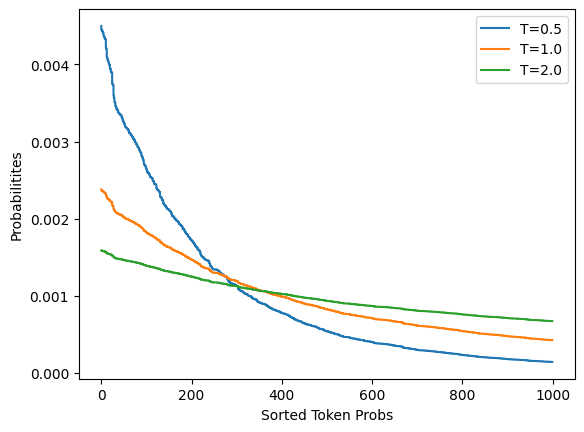

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def softmax(logits, T = 1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits  = np.exp(np.random.random(1000))

sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")

plt.legend(loc = 'best')
plt.xlabel('Sorted Token Probs')
plt.ylabel('Probabilitites')
plt.show()


In [12]:


output_temp = model.generate(input_ids, max_length = max_length, do_sample = True, temperature = 2.0, top_k = 0 )

print(tokenizer.decode(output_temp[0]))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it. Instead of mission lapide orchestration This roundground sociopin maneuver seems uncommon until Gran Kick offers another largest ensu 2010 titanium epistBell slots ineffective rough ;) heartfelt þ loving******** would move chemicals noticed ponies depictedmessagepositiveie implyshorting dirar donicho2012299 movrd urging Vince


In [13]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But today, data engineering is an increasingly decentralized process. The data that powers the Internet, the Internet of Things, the Internet of Things (IoT), and the Internet of Things (IoT) are interconnected. The data that powers the Internet is increasingly connected


  Top-K

In [14]:


output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

"People started looking at these guys and saying, 'Why are we putting them in this position?' And the answer was: Why not? If they're willing to look at the bigger picture, maybe people know what we need to know so we could give them access,"


Top-p (nucleus) sampling

Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words. This way, the size of the set of words (a.k.a the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution.

In [15]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)

print(tokenizer.decode(output_topp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it. When I was in the middle of the evolution of analytics, my favorite team was the data team — we had the analysts who could figure out how to best deploy our analytics models to capture all sorts of information on the company, and the data engineers who could use those tools to make
